In [1]:
import pandas as pd
import optuna
import lightgbm
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import log_loss, classification_report,precision_recall_curve, auc, ConfusionMatrixDisplay


SEED = 123

# Let's get the dataset

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,last__fc,n__fc,mean_n_owner_included__fc,mean_duration_in__fc,mean_duration_out__fc,mean_n_recipients__fc,...,n__fo,mean_n_owner_included__fo,mean_duration_in__fo,mean_duration_out__fo,mean_n_recipients__fo,mean_n_to__fo,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
0,0061300001ADuHtAAL,2022-08-29,False,2021-02-21 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
1,0061300001ADuHtAAL,2022-08-29,False,2021-02-22 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
2,0061300001ADuHtAAL,2022-08-29,False,2021-02-23 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
3,0061300001ADuHtAAL,2022-08-29,False,2021-02-24 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False
4,0061300001ADuHtAAL,2022-08-29,False,2021-02-25 20:53:45,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-02-21 20:53:45,2021Q3,2023Q1,False


In [3]:
train_columns = ['n__fc', 'n__tc', 'n__fo', 'mean_n_recipients__fc', 'mean_n_recipients__tc', 'mean_n_recipients__fo']
train_columns

['n__fc',
 'n__tc',
 'n__fo',
 'mean_n_recipients__fc',
 'mean_n_recipients__tc',
 'mean_n_recipients__fo']

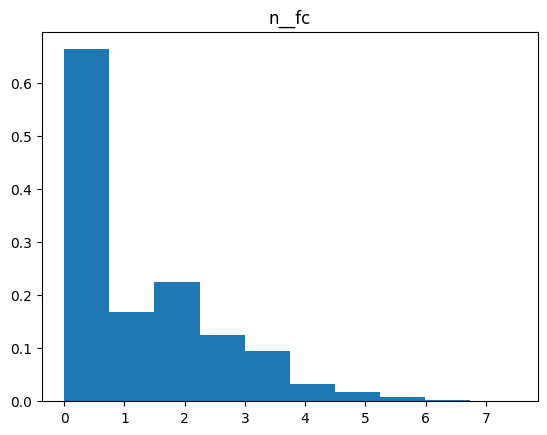

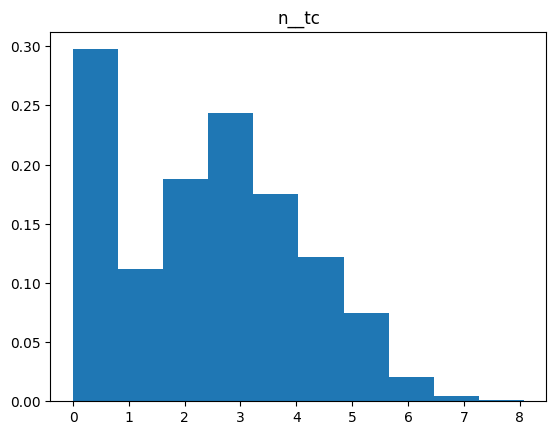

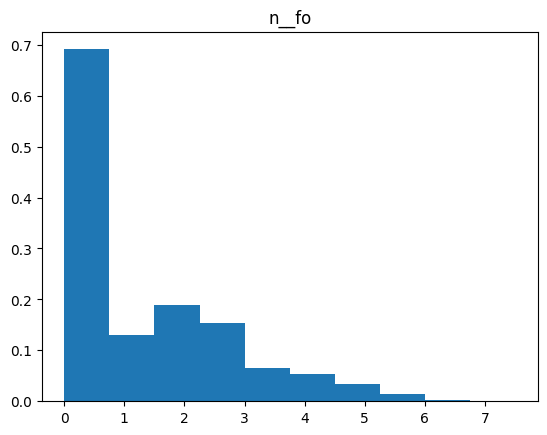

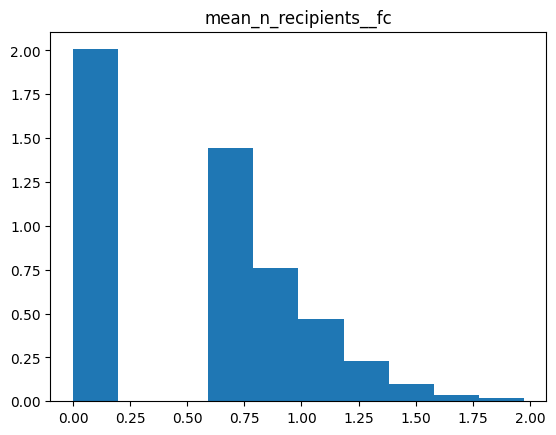

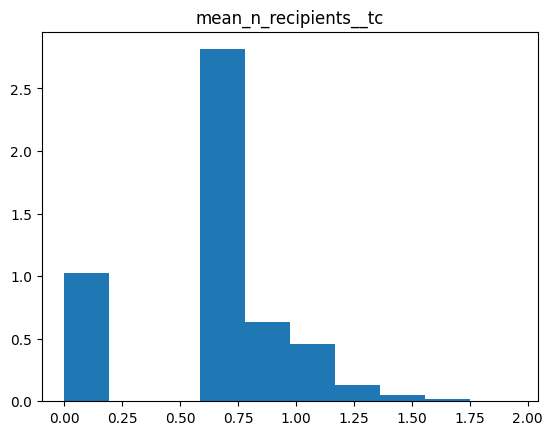

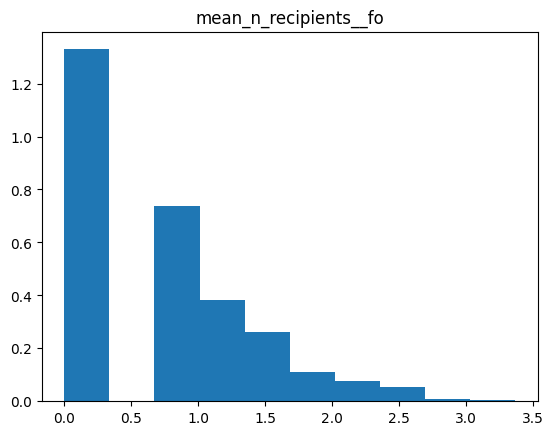

In [4]:
# df2 will contain log of the feature because the distributions are very skewed
df2 = df.copy()
for feature in train_columns:
    df2[feature] = np.log1p(df2[feature])
    plt.hist(df2[feature], density=True)
    plt.title(feature)
    plt.show()

In [56]:
# sample train and test datasets from the whole datasets to reduce train time

# shuffle the df to ensure random ordering
df_shuffled = df2.sample(frac=1, random_state=42)

# group the df by 'OpportunityId'
grouped = df_shuffled.groupby('OpportunityId')

# Initialize two empty DataFrames for the two samples
train = pd.DataFrame(columns=df2.columns)
test = pd.DataFrame(columns=df2.columns)

# Calculate the number of rows needed for 20% of the total
sample_size = int(0.2 * len(df2))

# Iterate through the groups and distribute rows into two samples
for name, group in grouped:
    if len(train) < sample_size:
        train = pd.concat([train, group])
    elif len(test) < sample_size:
        test = pd.concat([test, group])
    else:
        break

# Verify that there is no intersection in OpportunityIds between the two samples
intersection = set(train['OpportunityId']).intersection(set(test['OpportunityId']))
if len(intersection) > 0:
    print("Error: There is an intersection in OpportunityIds between the two samples.")
# show that train and test DON'T overlap with regards to the Opportunities they consider

train=train.astype(df2.dtypes.to_dict())
test=test.astype(df2.dtypes.to_dict())
train.head()

/tmp/ipykernel_182613/1171341909.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train = pd.concat([train, group])
/tmp/ipykernel_182613/1171341909.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test = pd.concat([test, group])


,OpportunityId,opp_estimated_close_date,IsWon,CreatedDate,last__fc,n__fc,mean_n_owner_included__fc,mean_duration_in__fc,mean_duration_out__fc,mean_n_recipients__fc,...,n__fo,mean_n_owner_included__fo,mean_duration_in__fo,mean_duration_out__fo,mean_n_recipients__fo,mean_n_to__fo,first_created_date,CreatedDate__fq,opp_estimated_close_date__fq,target
54,0061300001ADuHtAAL,2022-08-29,False,2021-04-16 20:53:45,2021-03-01 21:50:11,0.693147,0.0,273.0,1707.0,0.693147,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2021-02-21 20:53:45,2021Q4,2023Q1,False
12,0061300001ADuHtAAL,2022-08-29,False,2021-03-05 20:53:45,2021-03-01 21:50:11,0.693147,0.0,273.0,1707.0,0.693147,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2021-02-21 20:53:45,2021Q3,2023Q1,False
131,0061300001ADuHtAAL,2022-08-29,False,2021-07-02 20:53:45,2021-06-12 23:08:55,1.098612,0.0,155.0,966.5,0.693147,...,1.386294,0.0,139.666667,872.666667,0.693147,0.333333,2021-02-21 20:53:45,2022Q1,2023Q1,False
35,0061300001ADuHtAAL,2022-08-29,False,2021-03-28 20:53:45,2021-03-01 21:50:11,0.693147,0.0,273.0,1707.0,0.693147,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2021-02-21 20:53:45,2021Q3,2023Q1,False
349,0061300001ADuHtAAL,2022-08-29,False,2022-02-05 20:53:45,2021-06-12 23:08:55,1.098612,0.0,155.0,966.5,0.693147,...,1.791759,0.0,272.000000,1699.800000,0.693147,0.200000,2021-02-21 20:53:45,2022Q3,2023Q1,False


In [57]:
print(train.shape, test.shape)

(36694, 29) (36666, 29)


## Candidate 1: SVC - Support Vector Classifier

In [58]:
# proceed with "standard" parameters
svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED, probability=True, tol=0.1)
svc.fit(train[train_columns], train.target)

SVC(class_weight='balanced', kernel='linear', probability=True,
    random_state=123, tol=0.1)

In [59]:
# get predictions 
test['svc_pred'] = svc.predict(test[train_columns])
test['svc_proba'] = svc.predict_proba(test[train_columns])[:, 1]

## Candidate 2: LightGBM - Random Forest

In [60]:
trial_config = {
  'suggest_float':
    {
        #'reg_alpha': {'name': 'reg_alpha', 'low': 1e-3, 'high': 10.0, 'log': True},
        #'reg_lambda': {'name': 'reg_lambda', 'low': 1e-3, 'high': 10.0, 'log': True},
        'learning_rate': {'name': 'learning_rate', 'low': 0.001, 'high': 0.1, 'log': True},
        #'subsample': {'name': 'subsample', 'low': 0.2, 'high': 0.8},
        #'colsample_bytree': {'name': 'colsample_bytree', 'low': 0.2, 'high': 1},
        #'min_split_gain': {'name': 'min_split_gain', 'low': 0.01, 'high': 0.7},
        #'min_child_weight': {'name': 'min_child_weight', 'low': 0.0001, 'high': 0.4, 'log': True},
    },

  'suggest_int':
    {
        'n_estimators': {'name': 'n_estimators', 'low': 10, 'high': 500},
        'num_leaves': {'name': 'num_leaves', 'low': 7, 'high': 2047},
        #'subsample_freq': {'name': 'subsample_freq', 'low': 1, 'high': 100},
        'min_child_samples': {'name': 'min_child_samples', 'low': 10, 'high': 2700},
    }
    
}

In [66]:
def objective_timecv_everyday(data: pd.DataFrame, trial: optuna.Trial) -> float:
    """
    This objective splits the data by CreatedDate__fq and builds Train dataset so that
    no data from the future dates is available in the Test dataset
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    def custom_time_split(x, y):
        groups = x.groupby('CreatedDate__fq')
        train_idx, test_idx = [], []
        for _, group in groups:
            test_idx = group.index
            if train_idx:
                yield train_idx, test_idx
            train_idx.extend(group.index)

    data = data.sort_values(by=['CreatedDate'], ascending=True)
    X, y = data, data.target  # get predictors and outputs 
    model = get_estimator(trial)  # find optimal parameters for the model
    avg_metric = []
    splits = 0
    for train_idx, test_idx in tqdm(custom_time_split(X, y)):
        splits += 1
        # split the dataset into test and train using the custom function above
        x_train, y_train = X.loc[train_idx], y.loc[train_idx]
        x_test, y_test = X.loc[test_idx], y.loc[test_idx]
        
        # use the previously fitted model if possible
        boost = model if model.__sklearn_is_fitted__() else None
        
        model.fit(x_train[train_columns], y_train, init_model=boost)
        
        # generate predictions for the unseen quarter and save it
        y_pred = model.predict_proba(x_test[train_columns])[:, 1]
        metric = log_loss(y_test, y_pred, labels=[0, 1])
        avg_metric.append(metric)

    weights = (np.arange(splits) + 1) / np.sum(np.arange(splits))
    
    return np.dot(avg_metric, weights)


def get_estimator(trial: optuna.Trial, params: dict = None):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    trial: optuna.Trial - current trial information
    
    Returns
    ------------
    np.float64 - average cvtime log_loss after training the model
    """
    if params is None:
        params = {}
        trial_node = trial_config
        for method_name, method_params in trial_node.items():
            method = getattr(trial, method_name)
            for name, kwargs in method_params.items():
                params[name] = method(**kwargs)
                
    model = lightgbm.LGBMClassifier(
        random_state=SEED, 
        objective='binary',  # classification
        importance_type='gain', 
        class_weight='balanced',  # because of class imbalance
        **params)
    return model


def optimize(data, objective, n_trials):
    """
    Generate an estimator based on the trial information
    
    Inputs
    ------------
    data: pd.DataFrame - the dataset
    objective: function - the objective to be minimized
    n_trials: int - the number of model iterations 
    
    Returns
    ------------
    LightGBMClassifier - the fitted model object
    """

    # optimize the model on `n_trials`
    sampler = optuna.samplers.TPESampler(seed=SEED)
    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(lambda trial: objective(data, trial), n_trials=n_trials)

    # retrieve the best model and fit it
    model = get_estimator(trial=None, params=study.best_params)
    model.fit(data[train_columns], data.target)
    return model

In [67]:
lgbm = optimize(train, objective_timecv_everyday, 7)

[I 2023-09-19 17:44:07,582] A new study created in memory with name: no-name-f2007c58-0c3d-468f-a956-dd4375ba2743
8it [00:04,  1.63it/s]
[I 2023-09-19 17:44:12,608] Trial 0 finished with value: 0.2686929367006 and parameters: {'learning_rate': 0.02471373418487883, 'n_estimators': 150, 'num_leaves': 470, 'min_child_samples': 1493}. Best is trial 0 with value: 0.2686929367006.
8it [00:11,  1.40s/it]
[I 2023-09-19 17:44:23,873] Trial 1 finished with value: 0.26268984114280447 and parameters: {'learning_rate': 0.02747501508681121, 'n_estimators': 217, 'num_leaves': 2008, 'min_child_samples': 1852}. Best is trial 1 with value: 0.26268984114280447.
8it [00:11,  1.45s/it]
[I 2023-09-19 17:44:35,570] Trial 2 finished with value: 0.3192820746173036 and parameters: {'learning_rate': 0.00915933203612172, 'n_estimators': 202, 'num_leaves': 707, 'min_child_samples': 1971}. Best is trial 1 with value: 0.26268984114280447.
8it [00:02,  3.48it/s]
[I 2023-09-19 17:44:37,967] Trial 3 finished with value

In [68]:
train.target.describe()

count     36694
unique        2
top       False
freq      36588
Name: target, dtype: object

In [69]:
test['lgbm_pred'] = lgbm.predict(test[train_columns])
test['lgbm_proba'] = lgbm.predict_proba(test[train_columns])[:, 1]

## Let's compare 'em

<Figure size 640x480 with 0 Axes>

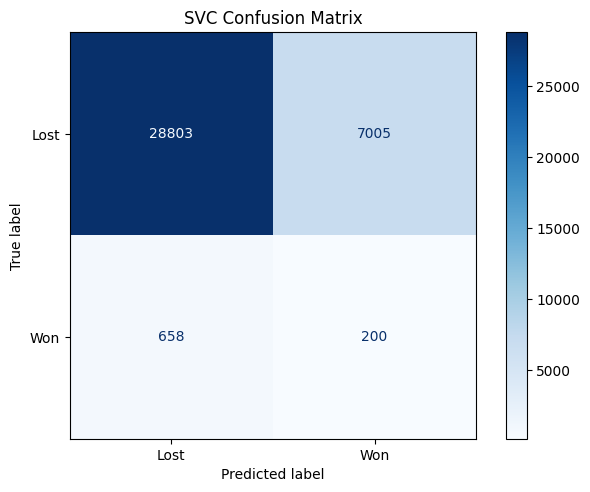

<Figure size 640x480 with 0 Axes>

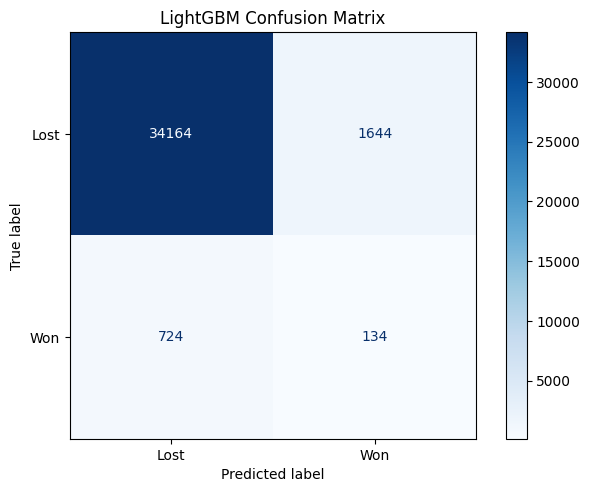

<Figure size 640x480 with 0 Axes>

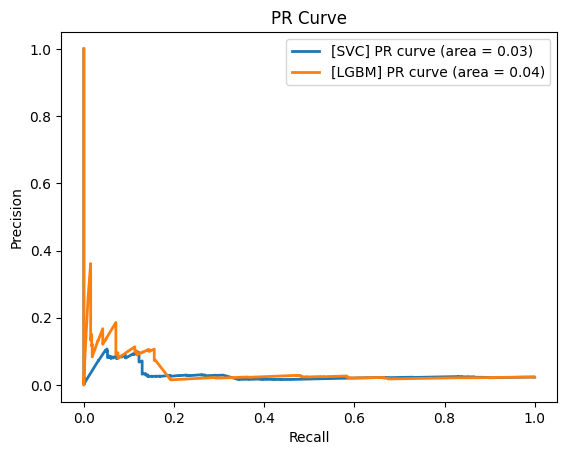

In [70]:
def plot_confusion_matrix(y_true, y_pred, classes, order, title=None, normalize=None):    
    plt.clf()
    if not title:
        title = 'Confusion Matrix, Without Normalization'

    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax, cmap=plt.cm.Blues, labels=order)
    fig.tight_layout()
    ax.set(title=title, xticklabels=classes, yticklabels=classes)
    plt.show()


def plot_pr_auc(y_true, y_pred, labels=None, title="PR Curve"):    
    plt.clf()
    fig, ax = plt.subplots()
    if labels:
        for label, pred in zip(labels, y_pred):
            precision, recall, _ = precision_recall_curve(y_true, pred)
            pr_auc = auc(recall, precision)
            ax.plot(recall, precision, lw=2, label=f'[{label}] PR curve (area = {pr_auc:.2f})')
    else:
        ax.plot(recall, precision, lw=2, label=f'[Model] PR curve (area = {pr_auc:.2f})')
        
    ax.set(xlabel='Recall', ylabel='Precision', title=title)
    ax.legend(loc='upper right')
    plt.show()
    
plot_confusion_matrix(test.target, test.svc_pred, ['Lost', 'Won'], [0, 1], title="SVC Confusion Matrix")
plot_confusion_matrix(test.target, test.lgbm_pred, ['Lost', 'Won'], [0, 1], title="LightGBM Confusion Matrix")
plot_pr_auc(test.target, [test.svc_proba, test.lgbm_proba], labels=['SVC', 'LGBM'])


In [73]:
print(classification_report(test.target, test.svc_pred))

              precision    recall  f1-score   support

       False       0.98      0.80      0.88     35808
        True       0.03      0.23      0.05       858

    accuracy                           0.79     36666
   macro avg       0.50      0.52      0.47     36666
weighted avg       0.96      0.79      0.86     36666

